In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from alertstack.analyse import Analyse
from alertstack.scramble_catalogues.blazar_catalogue import Fermi4FGLBlazarCatalogue, AverageFluxWeightHypothesis
from alertstack.fixed_catalogues.icecube_neutrino_alerts import CircularisedNeutrinoAlertCatalogue
from alertstack.stats import GammaDistribution
from examples.fermi_neutrino_alert import blazar_analysis

In [15]:
# blazars = Fermi4FGLBlazarCatalogue()

# blazars.data = blazars.data
# # print(blazars.data["Flux1000"][:5])
# nu_cat = CircularisedNeutrinoAlertCatalogue()
# nu_cat.data = nu_cat.data

# print(len(nu_cat.data))

# ana = Analyse(
#     blazars,
#     [AverageFluxWeightHypothesis],
#     nu_cat,
#     blazar_cache
# )

In [16]:
# all_res = ana.iterate_run(n_trials=5000, injection_hypo=AverageFluxWeightHypothesis, fraction=0.3, nsteps=10)

all_res = blazar_analysis.load_results()
    # input("?")

Saving to: /Users/robertstein/Code/alertstack/examples/fermi_neutrino_alert/cache/None.pkl
dict_keys([0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0])


In [17]:
sens_threshold = dict()
disc_3_threshold = dict()
disc_4_threshold = dict()
disc_5_threshold = dict()
disc_6_threshold = dict()

zero_key = 0.0

for key, val in all_res[zero_key].items():
    sens_threshold[key] = np.median(val)
    gd = GammaDistribution(val)
    disc_3_threshold[key] = gd.calculate_discovery_potential(3.)
    disc_4_threshold[key] = gd.calculate_discovery_potential(4.)
    disc_5_threshold[key] = gd.calculate_discovery_potential(5.)
    disc_6_threshold[key] = gd.calculate_discovery_potential(6.)
    # print(Chi2(val))

      fun: 133058.12095276878
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00582077, -0.00582077, -0.02037268])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 156
      nit: 32
   status: 0
  success: True
        x: array([ 4.78437696, -3.68574667,  1.32034567])


      fun: 133058.12095276878
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00582077, -0.00582077, -0.02037268])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 156
      nit: 32
   status: 0
  success: True
        x: array([ 4.78437696, -3.68574667,  1.32034567])
3 Sigma Discovery Potential: 14.838676040515432
0.9986500775574758
4 Sigma Discovery Potential: 21.160671092708608
0.9999683281854397
5 Sigma Discovery Potential: 28.618237984309186
0.9999997133432444
6 Sigma Discovery Potential: 37.243772326780935
0.9999999990133944


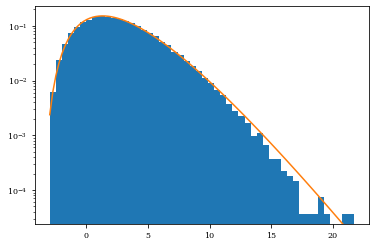

In [18]:
for key, val in all_res[zero_key].items():
    
    gd = GammaDistribution(val)
    
    data = np.array(val)
    
#     bins = np.histogram(data, bins=20)
#     print(np.log(bins[0]), len(bins[0]), len(bins[1]))
    
#     x_vals = [np.mean([x + bins[1][i+1]]) for i, x in enumerate(bins[1][:-1])]
    
#     plt.plot(x_vals, np.log(bins[0]))
    
#     print(x_vals, np.log(bins[0]))
    
    weights = np.ones(len(val))
    weights /= np.sum(weights)
    mask = data > 0.
    
    plt.hist(data, density=True, bins=50)
#     plt.hist(data[mask], weights=weights[mask])
#     plt.hist(data[~mask], weights=weights[~mask], color="grey")
    x_range = np.linspace(min(data), max(data), 100)
#     plt.plot(x_range, scipy.stats.gamma.pdf(x_range, res["x"][0], loc=0., scale=res["x"][1]))
    plt.yscale("log")
    ylim = plt.gca().get_ylim()
    plt.plot(x_range, gd.dist.pdf(x_range))#*(1 - gd.frac_under_zero))
    plt.gca().set_ylim(ylim)
    
    for i in [3, 4, 5, 6]:
        disc_threshold = gd.calculate_discovery_potential(i)
        print("{0} Sigma Discovery Potential: {1}".format(i, disc_threshold))
        print(gd.dist.cdf(disc_threshold))# + gd.frac_under_zero)

In [7]:
levels = [
    ("Background Median", sens_threshold),
    ("3 Sigma Discovery Potential", disc_3_threshold),
    ("4 Sigma Discovery Potential", disc_4_threshold),
    ("5 Sigma Discovery Potential", disc_5_threshold),
    ("6 Sigma Discovery Potential", disc_6_threshold)
]


for step, res in all_res.items():
    print("Fraction of neutrino alerts correlated to source: {0} \n".format(step))

    bkgs = dict()

    for key, val in res.items():
        print(key, np.mean(val), np.median(val), np.std(val))
        val = np.array(val)

        for name, thresh in levels:
            print(thresh[key])
            print("Fraction above {0}: {1}".format(
                name, np.sum(val > thresh[key])/float(len(val))))

Fraction of neutrino alerts correlated to source: 0.0 

average_flux_weight 2.6625021565988276 2.2448944825531516 2.8851264348407146
2.2448944825531516
Fraction above Background Median: 0.5
15.019344523425952
Fraction above 3 Sigma Discovery Potential: 0.0005660377358490566
21.424760715715795
Fraction above 4 Sigma Discovery Potential: 0.0
28.982700326172377
Fraction above 5 Sigma Discovery Potential: 0.0
37.72602188185783
Fraction above 6 Sigma Discovery Potential: 0.0
Fraction of neutrino alerts correlated to source: 0.2 

average_flux_weight 27.55471477043808 27.191371122364085 9.181389228104088
2.2448944825531516
Fraction above Background Median: 1.0
15.019344523425952
Fraction above 3 Sigma Discovery Potential: 0.9188679245283019
21.424760715715795
Fraction above 4 Sigma Discovery Potential: 0.7433962264150943
28.982700326172377
Fraction above 5 Sigma Discovery Potential: 0.41320754716981134
37.72602188185783
Fraction above 6 Sigma Discovery Potential: 0.13584905660377358
Fraction

In [8]:
# for key, val in all_res[zero_key].items():
#     weights = np.ones_like(val)/float(len(val))
#     plt.hist(val, weights=weights, bins=50)
#     plt.title(key)
#     plt.yscale("log")
#     plt.figure()
#     plt.hist(val, weights=weights, cumulative=True, bins=50)

(array([ 96.,  78., 107., 102.,  91.,  97., 115., 105., 106., 103.]),
 array([-9.99777414e-01, -7.99836128e-01, -5.99894842e-01, -3.99953556e-01,
        -2.00012269e-01, -7.09833371e-05,  1.99870303e-01,  3.99811589e-01,
         5.99752875e-01,  7.99694161e-01,  9.99635447e-01]),
 <a list of 10 Patch objects>)

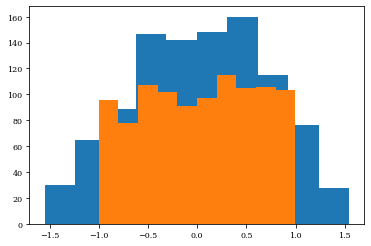

In [9]:
import numpy as np
res = np.arccos(np.random.uniform(size=1000)*2 - 1) - np.pi/2.
plt.hist(res)
plt.hist(np.cos(np.pi/2. - res))